In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from dataclasses import dataclass
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import requests
import pandas as pd
import json
import helper_functions

<Axes: xlabel='sqrtPrice'>

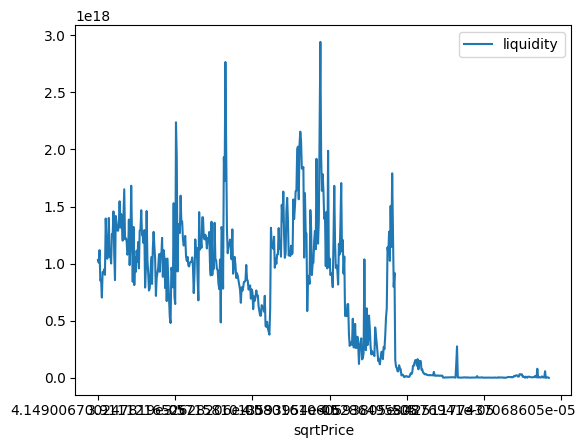

In [9]:
number_of_days=1000

#Treatment pools
#treatment_pool_id="0x4a5a2a152e985078e1a4aa9c3362c412b7dd0a86"  #wstETH/WETH 0.05%
#treatment_pool_id="0x1c3140ab59d6caf9fa7459c6f83d4b52ba881d36" #OP/USDC 0.3%
#treatment_pool_id="0xbf16ef186e715668aa29cef57e2fd7f9d48adfe6" #USDC/DAI 0.01%
treatment_pool_id="0x03af20bdaaffb4cc0a521796a223f7d85e2aac31" #WETH/DAI 0.3%
treatment_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"

#Control pools
#control_pool_id="0xd340b57aacdd10f96fc1cf10e15921936f41e29c" #wstETH/ETH 0.05% on ETH
#control_pool_id="0x68f5c0a2de713a54991e01858fd27a3832401849" #WETH/OP 0.3%
#control_pool_id="0xf1f199342687a7d78bcc16fce79fa2665ef870e1" #USDC/USDT 0.01% 
control_pool_id="0x85149247691df622eaf1a8bd0cafd40bc45154a9"  #WETH/USDC 0.05%
control_url="https://api.thegraph.com/subgraphs/name/ianlapham/optimism-post-regenesis"
#control_url="https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"

# Define Incentive and sample periods

uniswap_data = helper_functions.get_uniswap_data(treatment_pool_id,number_of_days,treatment_url)
treatment_df = pd.DataFrame(uniswap_data)
treatment_df=helper_functions.preprocess_data(treatment_df)

uniswap_data = helper_functions.get_uniswap_data(control_pool_id,number_of_days,control_url)
control_df = pd.DataFrame(uniswap_data)
control_df=helper_functions.preprocess_data(control_df)
control_df.plot('sqrtPrice','liquidity')

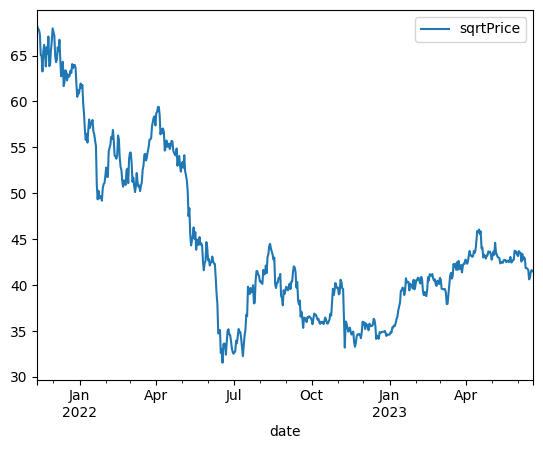

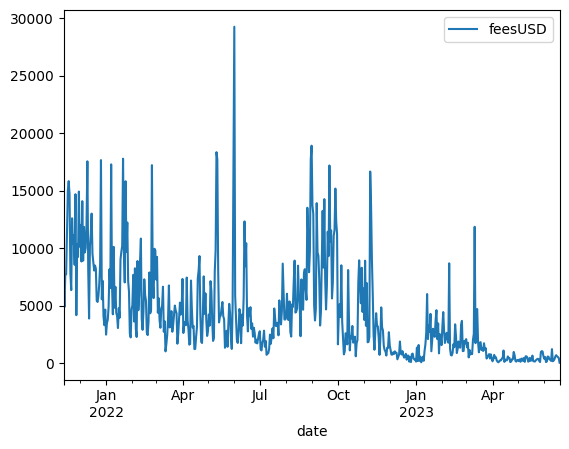

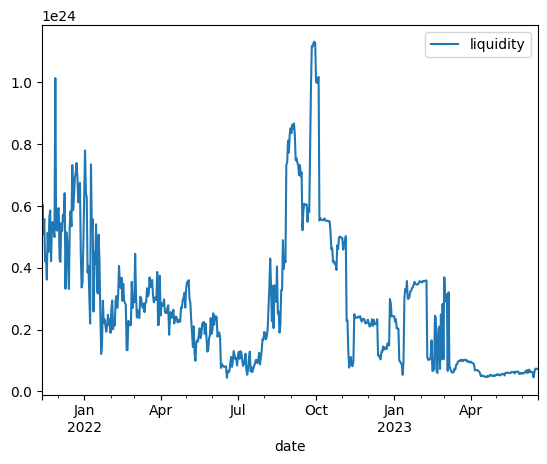

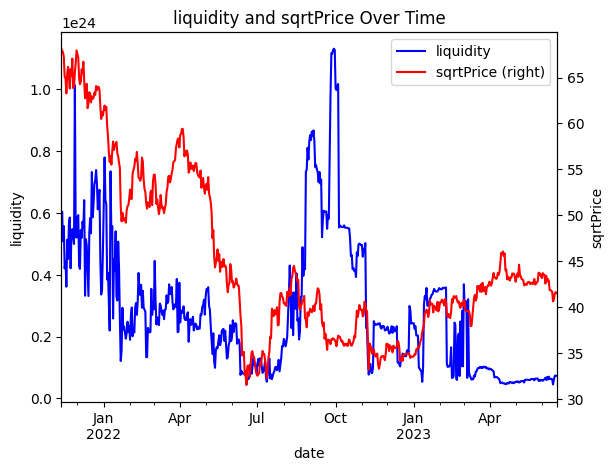

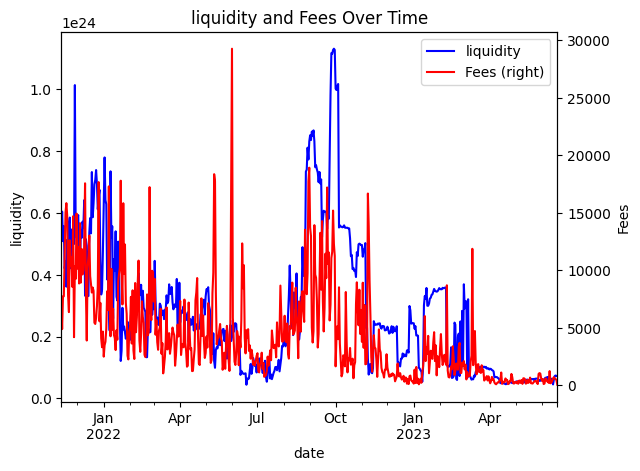

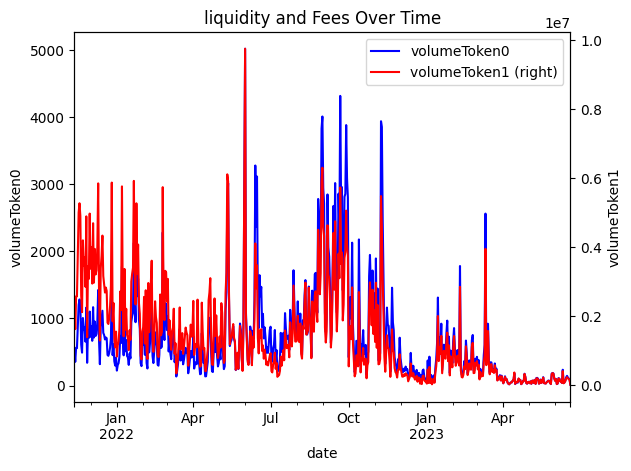

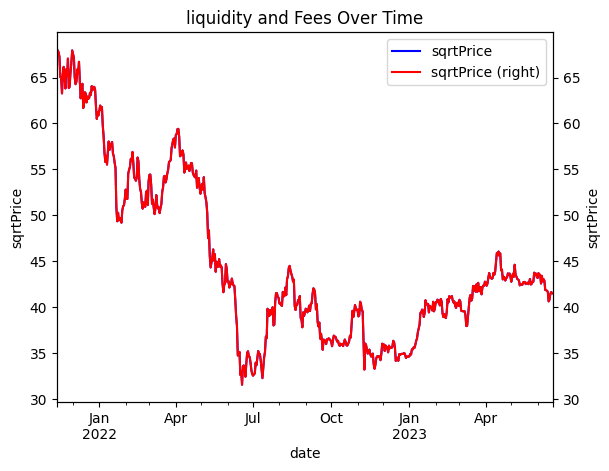

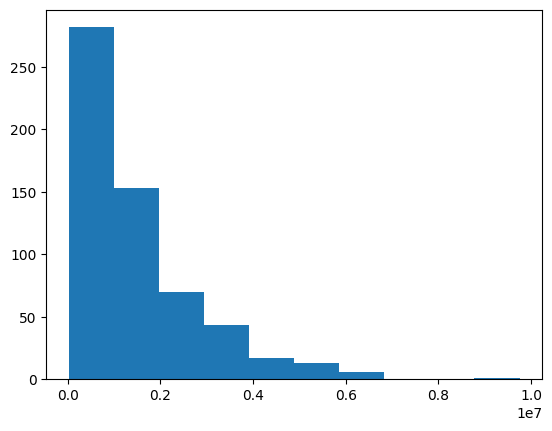

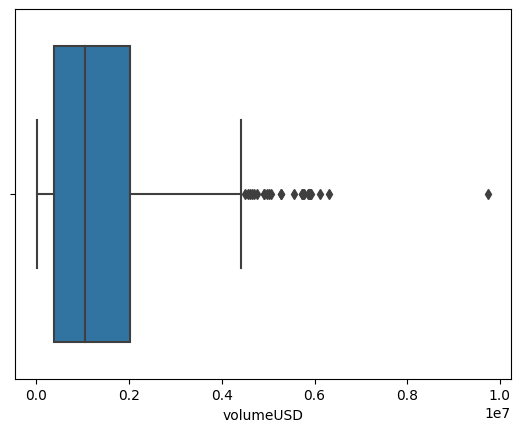

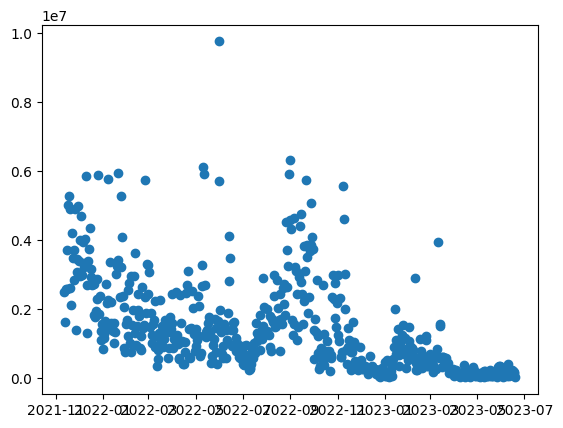

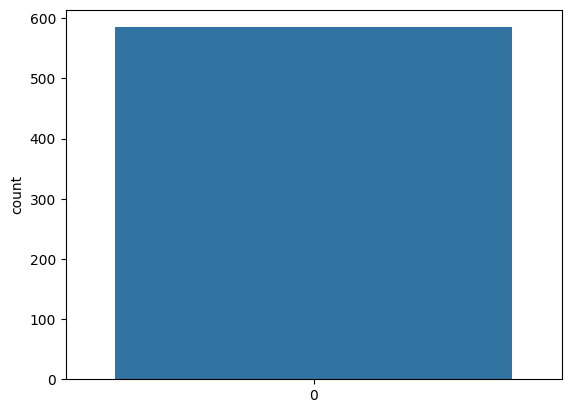

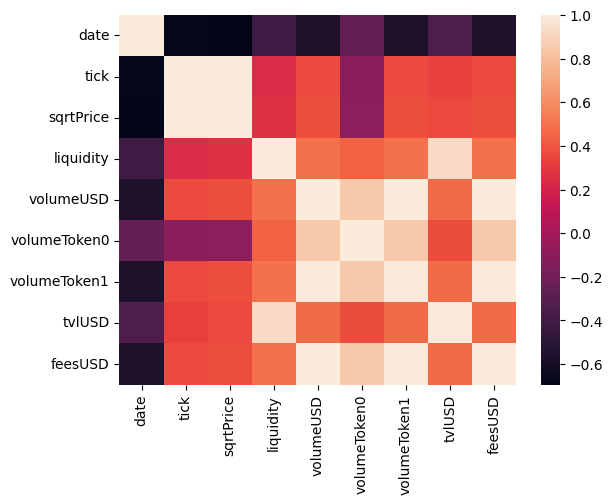

          date   tick  sqrtPrice     liquidity     volumeUSD  volumeToken0   
223 2022-11-08  71995  36.582903  1.299545e+23  5.556847e+06   3936.727680  \
271 2022-09-21  71306  35.343806  5.486243e+23  5.732898e+06   4314.113217   
292 2022-08-31  73467  39.376735  8.312716e+23  6.305448e+06   4007.282338   
293 2022-08-30  73288  39.027333  7.728470e+23  5.907542e+06   3826.857462   
383 2022-06-01  75095   42.71704  1.988469e+23  9.749704e+06   5016.739633   
384 2022-05-31  75746  44.130648  1.856111e+23  5.720300e+06   2921.765397   
403 2022-05-12  75830  44.314455  9.898436e+22  5.905769e+06   3014.083848   
404 2022-05-11  76379  45.548156  1.206082e+23  6.117442e+06   2729.053342   
480 2022-02-24  78604  50.907494  2.134584e+23  5.742182e+06   2281.299782   
514 2022-01-21  78599  50.895424  1.211577e+23  5.928442e+06   2124.729079   
528 2022-01-07  80803  56.825833  3.162811e+23  5.764632e+06   1773.305651   
540 2021-12-26  83176  63.982892  6.503722e+23  5.888509e+06   1

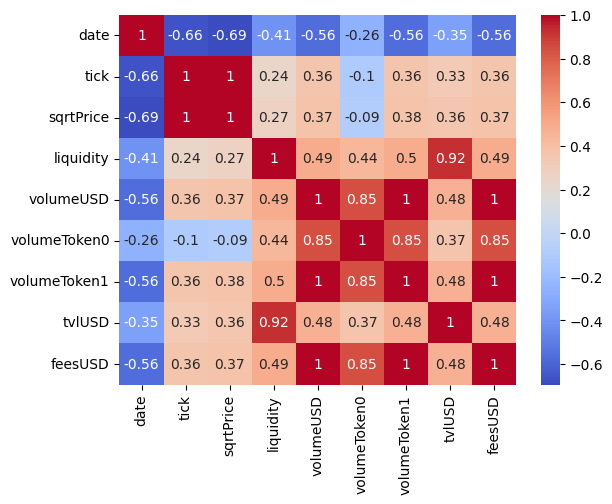

In [10]:
done=helper_functions.explore_data(treatment_df)

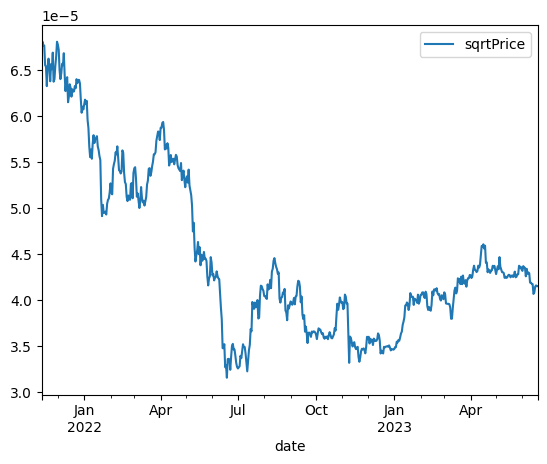

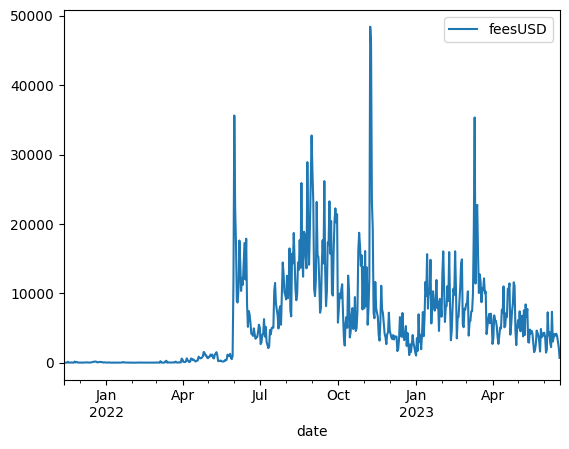

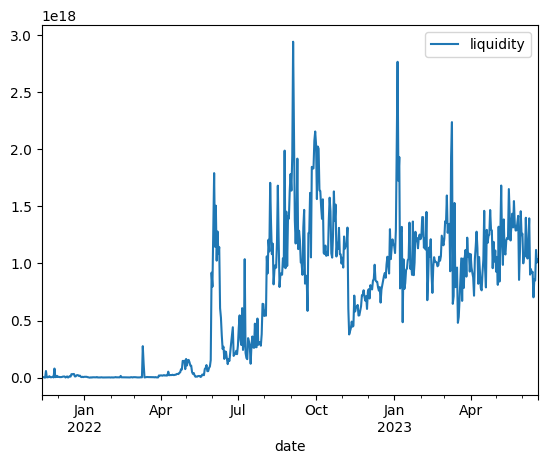

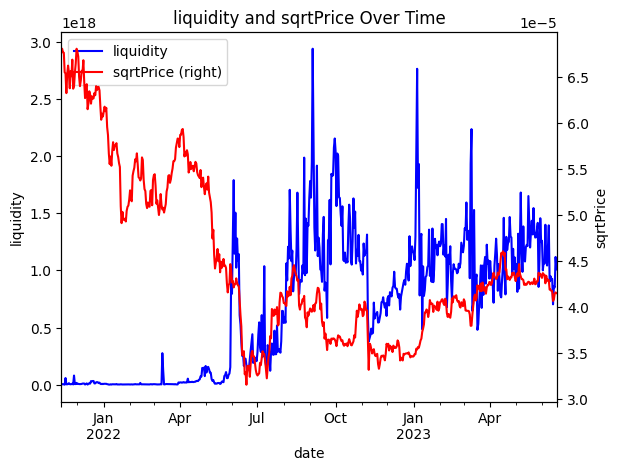

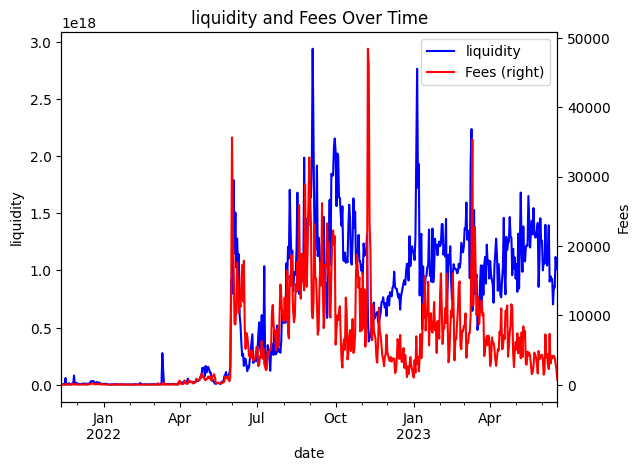

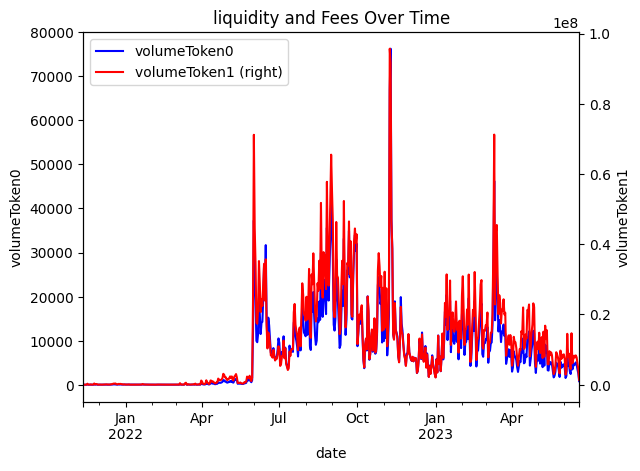

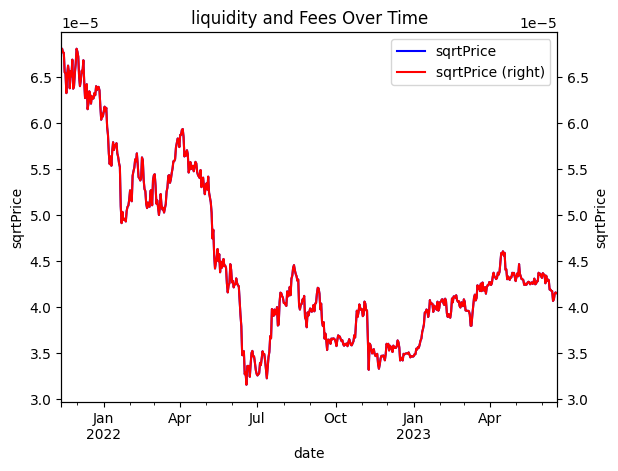

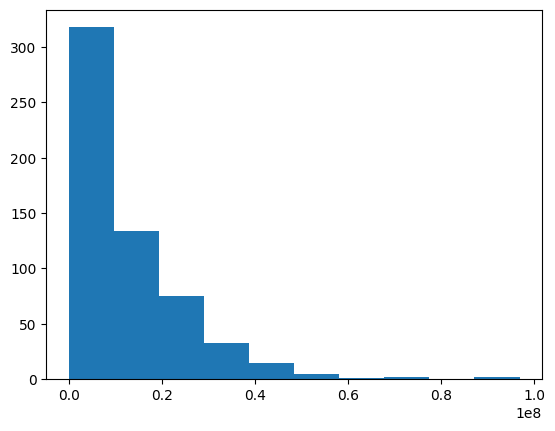

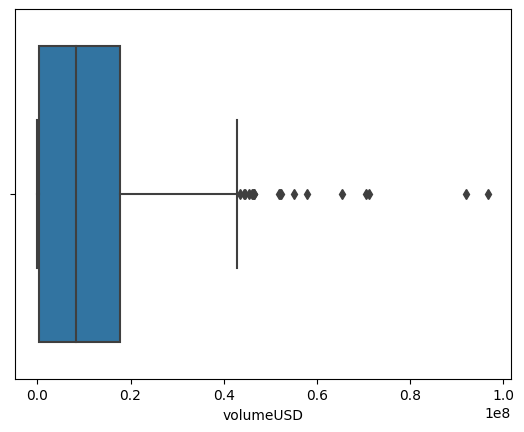

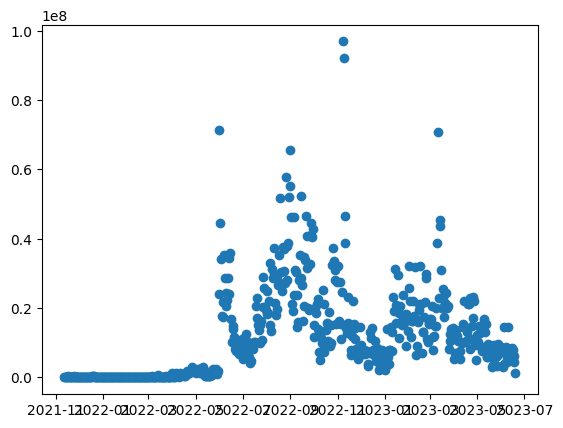

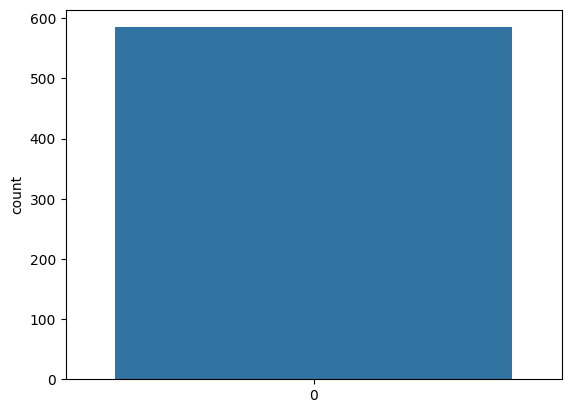

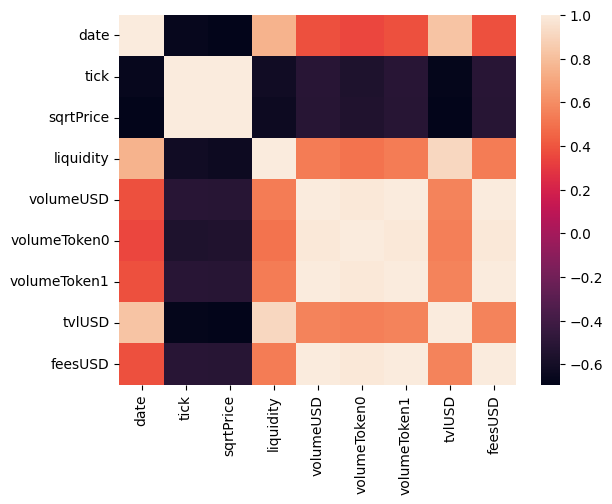

          date     tick sqrtPrice     liquidity     volumeUSD  volumeToken0   
100 2023-03-11  -202993  0.000039  6.467256e+17  7.067560e+07  46229.889113  \
222 2022-11-09  -206301  0.000033  3.788288e+17  9.202575e+07  76259.533778   
223 2022-11-08  -204361  0.000037  6.046332e+17  9.684416e+07  66984.576042   
277 2022-09-15  -203367  0.000038  9.005601e+17  5.235223e+07  33165.912014   
291 2022-09-01  -202635   0.00004  1.782966e+18  5.513993e+07  35487.336843   
292 2022-08-31  -202832  0.000039  1.635526e+18  6.548764e+07  41592.799872   
293 2022-08-30  -203030  0.000039  1.391937e+18  5.210613e+07  33730.560553   
297 2022-08-26  -203130  0.000039  9.587180e+17  5.781649e+07  35604.449566   
383 2022-06-01  -201257  0.000043  7.963268e+17  7.125144e+07  37279.128744   

     volumeToken1        tvlUSD       feesUSD    zscore  
100  7.121216e+07  7.900067e+06  35337.799798  4.415835  
222  9.163345e+07  5.980516e+06  46012.877412  6.017808  
223  9.566723e+07  9.294421e+06  48

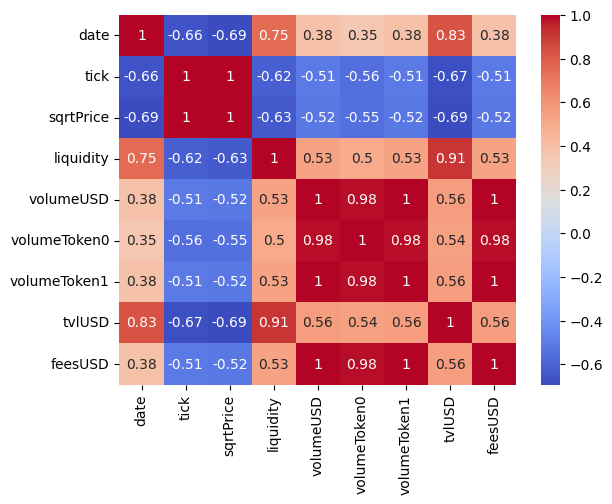

In [11]:
done=helper_functions.explore_data(control_df)

In [8]:
# Prepare training data
real_data = treatment_df  # Your real training data of token swap and add/remove liquidity events

# Generator model
def create_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_dim=10, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4)
    ])
    return model

# Discriminator model
def create_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, input_dim=4, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create GAN model
def create_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([
        generator,
        discriminator
    ])
    return model

# Real data
real_data = treatment_df['sqrtPrice']# ,'volumeUSD','liquidity','feesUSD']  # Your real training data of token swap and add/remove liquidity events

# Define GAN components
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)


# Define loss function and optimizers
loss_fn = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
batch_size = 32
num_epochs = 100

for epoch in range(num_epochs):
    for batch in range(len(real_data) // batch_size):
        # Generate random noise as input to the generator
        noise = tf.random.normal([batch_size, 10])

        # Generate synthetic events using the generator
        generated_data = generator(noise)

        # Combine real and generated data
        batch_real_data = real_data[batch * batch_size : (batch + 1) * batch_size]

        # Create labels for real and generated data
        labels_real = tf.ones((batch_size, 1))
        labels_generated = tf.zeros((batch_size, 1))
        labels_combined = tf.concat([labels_real, labels_generated], axis=0)

        # Train discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(batch_real_data)
            d_loss = loss_fn(labels_combined, predictions)
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

        # Train generator
        with tf.GradientTape() as tape:
            generated_data = generator(noise)
            predictions = discriminator(generated_data)
            g_loss = loss_fn(labels_real, predictions)
        grads = tape.gradient(g_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))


AttributeError: Exception encountered when calling layer 'sequential_16' (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received by layer 'sequential_16' (type Sequential):
  • inputs=0     41.540045
1     41.504031
2     41.630518
3     41.443634
4     40.823736
5      40.61826
6     41.673666
7     41.772636
8     41.859135
9     41.849874
10     42.86802
11    43.040087
12     42.79039
13    43.399227
14    42.564143
15    43.524013
16    43.492581
17    43.700777
18    43.160828
19    43.294417
20     43.65477
21    43.485282
22    43.750598
23     42.77449
24    42.726433
25    42.533506
26    42.456443
27    43.067109
28    42.682928
29    42.493228
30    42.662535
31    42.613396
Name: sqrtPrice, dtype: object
  • training=None
  • mask=None


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 3, 12, 9)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 3, 12, 9)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 15.09s


<Axes: xlabel='timestep'>

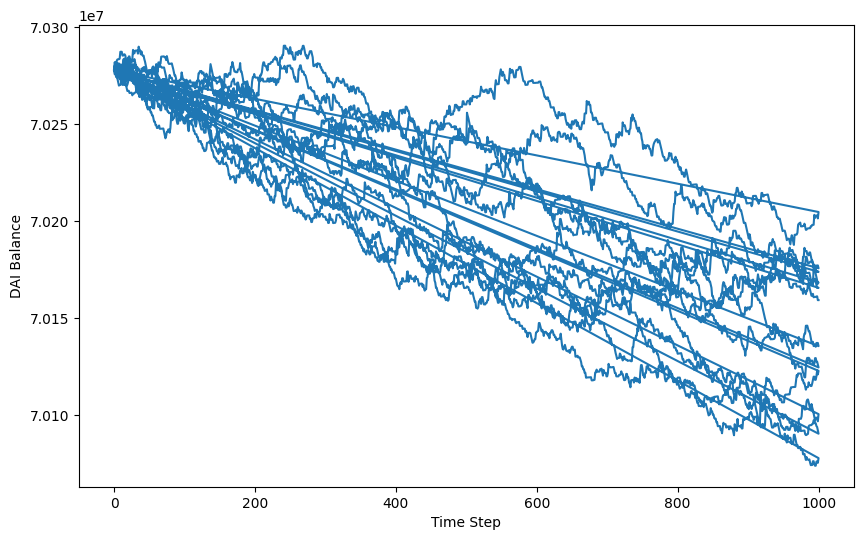

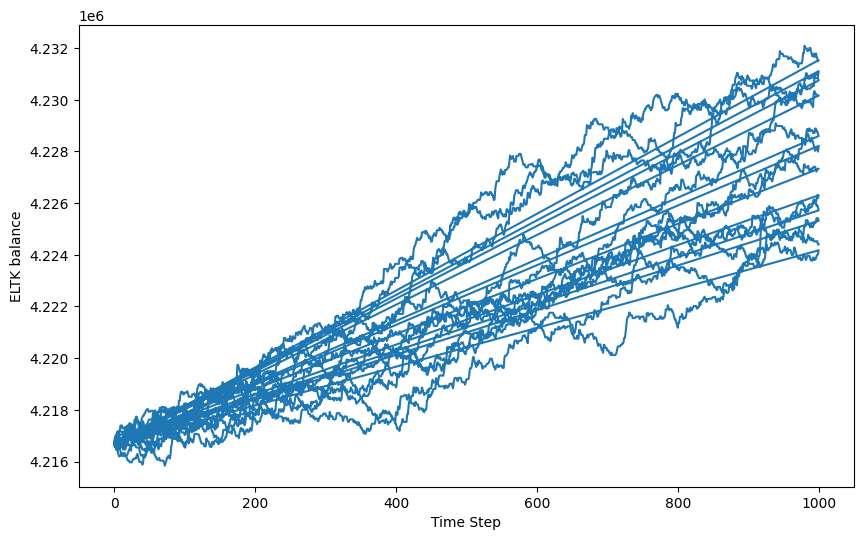

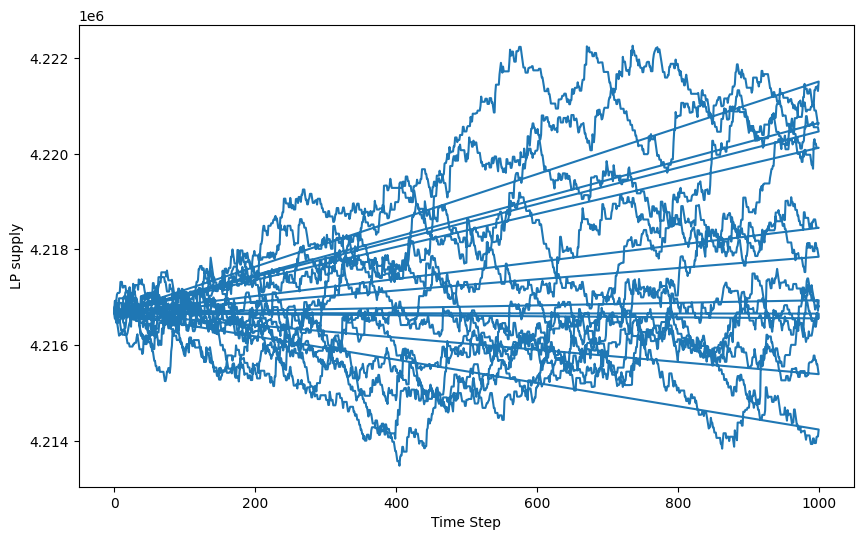

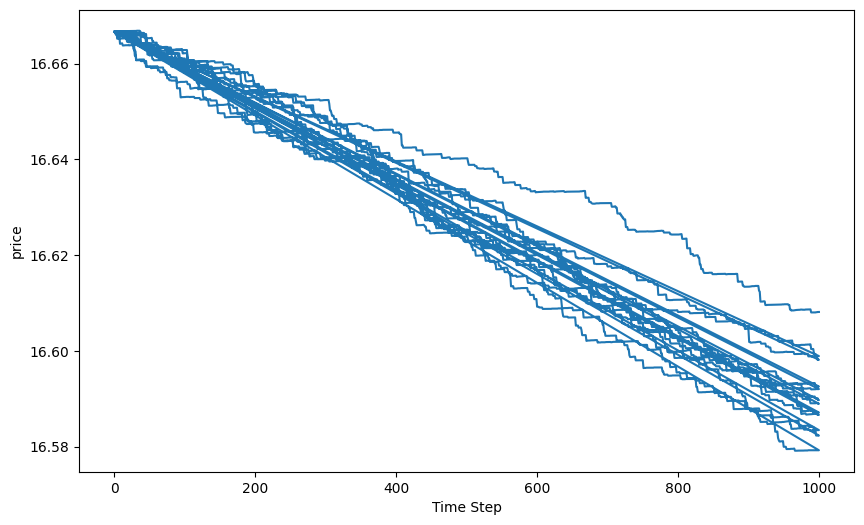

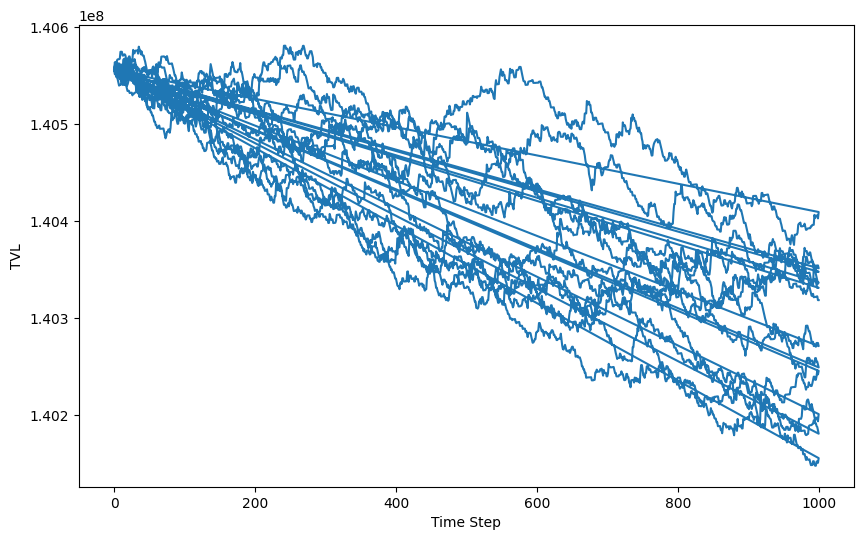

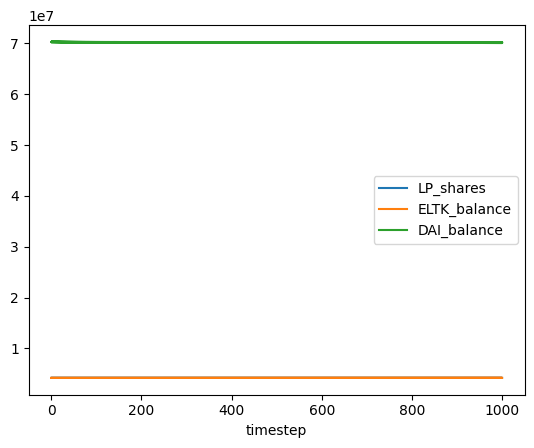

In [13]:
import pandas as pd
pd.set_option('max_colwidth', 70)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import random
from scipy.stats import expon, gamma

#Hypermeters
lambda_rate = 5000  # average rate of swaps per unit time
mu_rate = 3000  # average rate of liquidity additions per unit time
nu_rate = 500  # average rate of liquidity removals per unit time
TIMESTEPS=1000
RUNS=3

state = {
    'DAI_balance': 70277778,#Initial state of pool
    'ELTK_balance': 4216667,
    'LM_rewards': 0.05,  # Liquidity Mining rewards/unit of liquiidty
    'cum_fees':0,
    'swap_volume':1000, #10 day rollong avg of swap volume    
}
state['token_price']=state['DAI_balance']/state['ELTK_balance']
state['LP_shares'] = state['ELTK_balance']
state['TVL']=state['ELTK_balance']*state['token_price']+state['DAI_balance']
state['liquidtty_depth'] = state['TVL']*state['token_price']

params = {
    'fee_numerator': [997],
    'fee_denominator': [1000],
    'reward_rate': [0,0.5,1,1.5]
}

#Add liquidity
def addLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ELTK_reserve = int(current_state['ELTK_balance'])
    liquidity_minted = int(input_['ELTK_deposit'] * total_liquidity // ELTK_reserve)
    return ('LP_shares', total_liquidity + liquidity_minted)

def addLiquidity_ELTK(params, step, history, current_state, input_):
    ELTK_reserve = int(current_state['ELTK_balance'])
    return ('ELTK_balance', ELTK_reserve + input_['ELTK_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    ELTK_reserve = int(current_state['ELTK_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['ELTK_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['ELTK_deposit'] * token_reserve // ELTK_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)


#Remove liquidity
def removeLiquidity_LP(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    amount = int(input_['LP_burn'])
    return ('LP_shares', int(total_liquidity - amount))

def removeLiquidity_ELTK(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    ELTK_reserve = int(current_state['ELTK_balance'])
    amount = int(input_['LP_burn'])
    ELTK_amount = int(amount * ELTK_reserve // total_liquidity)
    return ('ELTK_balance', int(ELTK_reserve - ELTK_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['LP_shares'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['LP_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

#Price(Helper function)
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

#Swap ELTK-token
#ELTK sold/deposited
def ELTKToToken_ELTK(params, step, history, current_state, input_):
    ELTK_sold = int(input_['ELTK_sold']) #amount of ELTK being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    return ('ELTK_balance', ELTK_reserve + ELTK_sold)

#DAI received
def ELTKToToken_DAI(params, step, history, current_state, input_):
    ELTK_sold = int(input_['ELTK_sold']) #amount of ELTK being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if ELTK_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(ELTK_sold, ELTK_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

 #Swap token-ELTK
 #ELTK recieved   
def tokenToELTK_ELTK(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    ELTK_reserve = int(current_state['ELTK_balance'])
    if tokens_sold == 0:
        return ('ELTK_balance', ELTK_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        ELTK_bought = int(getInputPrice(tokens_sold, token_reserve, ELTK_reserve, params))
        return ('ELTK_balance', ELTK_reserve - ELTK_bought)

 #tokens sold/depoisted   
def tokenToELTK_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)


def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'ELTK_sold': 0,
        'tokens_sold': 0,
        'ELTK_deposit': 0,
        'LP_burn': 0,        
    }
    
    # Generate a random event based on probability distribution
    events = ['TokenPurchase', 'ELTKPurchase', 'AddLiquidity', 'Transfer']
    event_probabilities = [0.25, 0.25, 0.25, 0.25]  # Example probabilities for each event
    event = np.random.choice(events, p=event_probabilities)
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        # Generate random values for eLTK_sold using a specific distribution
        ELTK_sold = np.random.normal(loc=5, scale=100)  # Example using normal distribution
        action['ELTK_sold'] = max(ELTK_sold, 0)  # Ensure non-negative value
    elif event == 'ELTKPurchase':
        # Generate random values for tokens_sold using a specific distribution
        tokens_sold = np.random.uniform(0, 100)  # Example using uniform distribution
        action['tokens_sold'] = tokens_sold
    elif event == 'AddLiquidity':
        # Generate random values for ELTK_deposit using a specific distribution
        ELTK_deposit = np.random.exponential(scale=100)  # Example using exponential distribution
        action['ELTK_deposit'] = ELTK_deposit
    elif event == 'Transfer':
        # Generate random values for LP_burn using a specific distribution
        LP_burn = np.random.poisson(lam=100)  # Example using Poisson distribution
        action['LP_burn'] = LP_burn

    return action

def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ELTKToToken_DAI(params, step, history, current_state, input_)
    elif action == 'ELTKPurchase':
        return tokenToELTK_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ELTK(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ELTKToToken_ELTK(params, step, history, current_state, input_)
    elif action == 'ELTKPurchase':
        return tokenToELTK_ELTK(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ELTK(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ELTK(params, step, history, current_state, input_)
    return('ELTK_balance', current_state['ELTK_balance'])

def mechanismHub_LP(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_LP(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_LP(params, step, history, current_state, input_)
    return('LP_shares', current_state['LP_shares'])
    


partial_state_update_blocks = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ELTK_balance': mechanismHub_ELTK,
            'LP_shares': mechanismHub_LP
        }
    }
]
# Simulation Parameters
sim_config = {
    'N': RUNS,
    'T': range(TIMESTEPS),
    'M': params
}
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()
df = pd.DataFrame(raw_system_events)
plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['DAI_balance'])
plt.xlabel('Time Step')
plt.ylabel('DAI Balance')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['ELTK_balance'])
plt.xlabel('Time Step')
plt.ylabel('ELTK balance')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['LP_shares'])
plt.xlabel('Time Step')
plt.ylabel('LP supply')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], df['DAI_balance']/df['ELTK_balance'])
plt.xlabel('Time Step')
plt.ylabel('price')

plt.figure(figsize=(10, 6))
plt.plot(df['timestep'], (df['DAI_balance']+df['ELTK_balance']*(df['DAI_balance']/df['ELTK_balance'])))
plt.xlabel('Time Step')
plt.ylabel('TVL')
df.plot(x='timestep',y=['LP_shares','ELTK_balance','DAI_balance'])

In [33]:
import seaborn as sns

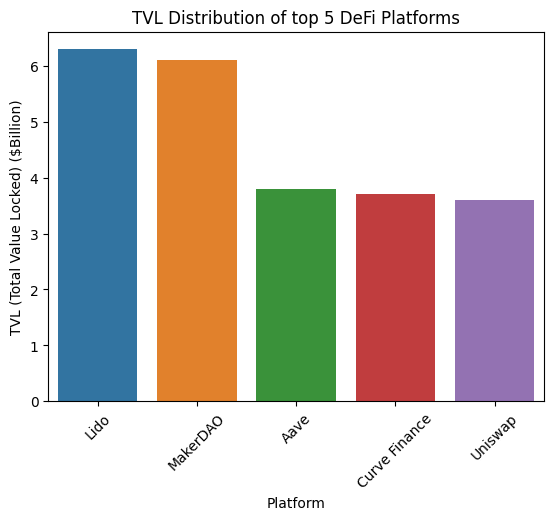

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

platforms = np.array(['Lido', 'MakerDAO', 'Aave', 'Curve Finance', 'Uniswap'])
TVL = np.array([6.3, 6.1, 3.8, 3.7, 3.6])

sns.barplot(x=platforms, y=TVL)
plt.xlabel('Platform')
plt.ylabel('TVL (Total Value Locked) ($Billion)')
plt.title('TVL Distribution of top 5 DeFi Platforms')
plt.xticks(rotation=45)
plt.show()
